In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso #because we are selecting features.
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor #worst performer because there is no pruning?

# ENSEMBLE

## Bagging (bootstrap aggregation) #likely to overfit too because its underlying uses decision tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


# for cross-validation
from sklearn.model_selection import cross_val_score #perf, mean, variance and std error
from sklearn.model_selection import KFold # we can tune it as hyperparameter
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

#import dependency for time series modelling

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix #plot of correlation matrix and kernel density plotting

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler


In [3]:
class Backtest:
    def __init__(self,data, base_, tradingexp_):
        self.data=data
        self.base=base_
        self.tradingexp = tradingexp_
        ## Write any processing that needs to be done on the data
        self.data['Buy_Sell']= self.data['Position'] - self.data['Position'].shift(1)
        self.data['log_return']=np.log(self.data['Adj Close']/self.data['Adj Close'].shift(1))
        self.data['Strategy_return']=self.data['Position'].shift(1)*self.data['log_return']
        self.data['Expense']=np.where(abs(self.data['Buy_Sell'])> 0, self.tradingexp, 0)
        self.data['Capital']= self.base*self.data['Strategy_return'].cumsum().apply(np.exp)
        self.data['Adj Capital'] = self.base*self.data['Strategy_return'].cumsum().apply(np.exp) - self.data['Expense'].shift(1).cumsum()
        self.data['Adj return'] = np.log(self.data['Adj Capital']/self.data['Adj Capital'].shift(1))
        self.data['drawdown']=self.data['Adj return'].cumsum() - self.data['Adj return'].cumsum().cummax()

                
    def plot_backtest_buy_sell(self): 
        ax=\
        (
            self.data[['Adj Close',
                       'Position']]
            .plot(figsize=(18,8),
                  secondary_y=["Position"],
                  style=["red","b--"],
                  alpha=0.5
                 )
        )

        (
            ax.legend(loc="upper center"
                      ,shadow=True
                      ,fancybox=True
                      ,bbox_to_anchor=(0.55,1.10)
                      ,ncol=4
                     )
        )

        bx=\
        (
            self.data[self.data['Buy_Sell']>0]['Adj Close']
            .plot(style="g^",
                  markersize=12,
                  label='Buy')
        )

        bx.legend()

        cx=\
        (
            self.data[self.data['Buy_Sell']<0]['Adj Close']
            .plot(style="rv",
                  markersize=12,
                  label="Sell")
        )
        
        cx.legend()
        plt.title(f"Backtest Buy Sell Signals")
        plt.show()
      
    def calculate_cumm_return(self):
        res=100*(np.exp(self.data['Adj return'].sum()) -1)
        print(f"Cummulative return is: {res:.2f}% with final Account balance: ${self.data['Adj Capital'].iloc[-1]}")

    def calculate_max_drawdown(self):
        res=100* (np.exp(self.data['drawdown'].min()) - 1)
        print(f"Max Drawdown: {res:.2f}%")
    
    def calculate_max_drawdown_duration(self):
        periods =\
        self.data[self.data['drawdown'] == 0].index[ 1 :   ].to_pydatetime() \
        - self.data[self.data['drawdown'] == 0].index[   : -1].to_pydatetime()
        print(f"Max Drawdown Duration: {periods.max()}")

    def calculate_return_byyear(self):
        grpByYear=self.data.groupby(self.data.index.year)
        return grpByYear['Adj return'].sum().apply(np.exp) -1

    def calculate_sharpe_ratio(self):
        res = np.sqrt(252) * (self.data['Adj return'].dropna().apply(np.exp).add(-1).mean()) / (self.data['Adj return'].dropna().apply(np.exp).add(-1).std())
        print(f"Sharpe Ratio: {res:.3f}")

    def calculate_cagr(self):
        days =(self.data.index[-1] - self.data.index[0]).days
        CAGR =100*(((np.exp(self.data['Adj return'].sum()))**(365.0/days)) - 1)
        print(f"Strategy CAGR is: {CAGR:.2f}%")
        
    def plot_backtest_returns(self):
        ax =\
        (
            self.data[["log_return", "Adj return"]]
            .dropna()
            .cumsum()
            .apply(np.exp)
            .add(-1)
            .plot(figsize = [18, 7])
        )
        
        ax.set_title(f"Back Test Strategy vs Asset Return")
        ax.legend(["Asset Cumm Return","Strategy Cumm Return (Adj)"])
        bx =\
        (
            self.data['Adj return']
            .cumsum()
            .cummax()
            .apply(np.exp)
            .add(-1)
            .plot(ax=ax)
        )
        plt.show()
    
    def plot_all_stats(self):
        self.calculate_cumm_return()
        self.calculate_cagr()
        self.calculate_max_drawdown()
        self.calculate_sharpe_ratio()
        self.plot_backtest_buy_sell()
        self.plot_backtest_returns()

# FEATURES

In [4]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"

tnx_ticker = "^TNX"

tnx_data = yf.download(tnx_ticker, start=start_date, end=end_date)

X0 = np.log(tnx_data["Adj Close"])
X0 = X0.ffill()
X0.name = "10years futures"

vix_ticker = "^VIX"

vix = yf.download(vix_ticker, start=start_date, end=end_date)

X0_1 = np.log(vix["Adj Close"])
X0_1 = X0_1.ffill()
X0_1.name = "vix"

X1 = np.log(spy["Volume"])
X2 =\
(pd.concat([Y.
            diff(i) 
            for i in [3,6,12]], 
                   axis = 1
          )
 #.dropna()
)
X2.columns = ["SPY_3", "SPY_6", "SPY_12"]

X3 =\
(
    pd.concat([X1.shift(i)
               #.diff(i) 
               for i in [3,6,12]],
                      axis =1
             )
)
X3.columns = ["Volume_3", "Volume_6", "Volume_12"]

X =\
(
        pd.concat([X0, X0_1, X1, X2, X3],
                 axis = 1)
)

#no trading signal for the first 12 days
X_traintest = X.iloc[12:]
Y_traintest = Y.iloc[12:]

X_traintest = X_traintest.ffill()


#interpreting Y returns in binary signal
Y_traintest_binary = (Y_traintest > 0).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
X_traintest

,10years futures,vix,Volume,SPY_3,SPY_6,SPY_12,Volume_3,Volume_6,Volume_12
Date,,,,,,,,,
2004-11-17,1.421662,2.580974,17.813601,-0.001105,0.000578,0.000997,17.833401,17.614546,17.418857
2004-11-18,1.415125,2.563410,17.276683,-0.003995,-0.018759,-0.023694,17.379334,17.628054,17.844605
2004-11-19,1.434132,2.602690,17.809602,-0.001163,-0.003102,-0.008804,17.505107,17.449490,18.158799
2004-11-22,1.426716,2.562639,17.441456,0.000176,-0.000929,-0.004719,17.813601,17.833401,17.829193
2004-11-23,1.431268,2.539237,17.552437,0.013546,0.009551,0.003817,17.276683,17.379334,17.963194
...,...,...,...,...,...,...,...,...,...
2023-10-25,1.599993,3.005187,18.361177,-0.010312,0.001368,-0.017238,18.634548,18.137319,18.202206
2023-10-26,1.577947,3.029167,18.561805,-0.012054,0.004282,-0.008631,18.337681,18.354111,18.179975
2023-10-27,1.577947,3.057298,18.491770,0.026341,0.024249,0.018000,18.179427,18.613967,17.949904


In [6]:
X_traintest.describe()

,10years futures,vix,Volume,SPY_3,SPY_6,SPY_12,Volume_3,Volume_6,Volume_12
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000
mean,0.949562,2.884216,18.485200,0.000006,-0.000003,-0.000014,18.484730,18.484225,18.483457
std,0.449800,0.374347,0.594471,0.017087,0.017530,0.017018,0.594907,0.595339,0.595927
min,-0.695149,2.212660,16.541401,-0.133988,-0.165888,-0.142857,16.541401,16.541401,16.541401
25%,0.676255,2.590767,18.038105,-0.007520,-0.007547,-0.007762,18.036886,18.035614,18.033281
50%,0.982453,2.826722,18.408187,-0.000337,-0.000367,-0.000343,18.407938,18.407802,18.405829
75%,1.307522,3.115513,18.886602,0.007142,0.007140,0.007184,18.886602,18.886602,18.886602
max,1.657847,4.415099,20.585183,0.161981,0.202618,0.135072,20.585183,20.585183,20.585183


In [7]:
Y_traintest

Date
2004-11-17    0.001348
2004-11-18   -0.011179
2004-11-19    0.004758
2004-11-22    0.001525
2004-11-23    0.002367
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [8]:
X_traintest.isna().any()

10years futures    False
vix                False
Volume             False
SPY_3              False
SPY_6              False
SPY_12             False
Volume_3           False
Volume_6           False
Volume_12          False
dtype: bool

In [9]:
Y_traintest.shift(-1)

Date
2004-11-17   -0.011179
2004-11-18    0.004758
2004-11-19    0.001525
2004-11-22    0.002367
2004-11-23   -0.000760
                ...   
2023-10-25   -0.004543
2023-10-26    0.011885
2023-10-27    0.006261
2023-10-30         NaN
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [ ]:
# Engineering more features
# Uses F-statistics to determine model significance

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

index_ = Y_traintest.shift(-1).dropna().index 

X_poly = poly.fit_transform(X_traintest.loc[index_])


from sklearn.feature_selection import SelectKBest, f_regression
#(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

#we are shifting the Y values because we need to train the model for a 1 day look ahead
X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

X_selected

In [ ]:
#get the features name used. Volume could be a cross-product or of a higher power

X_columns = selector.get_feature_names_out()

In [ ]:
X_columns

In [ ]:
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

In [ ]:
X_selected_df

In [ ]:
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso

#between 0 to 1 where 0 is Ridge and 1 is Lasso
penalty_ = 0.0

#linear_regression2 = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=penalty_)
#ridge_model = Ridge(alpha=1.0)
index_ = X_selected_df.index
elastic_net.fit(X_selected_df, Y_traintest.shift(-1).loc[index_])
print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

EN_pred_train2 = elastic_net.predict(X_selected_df)
print(EN_pred_train2)

#continuous predictions are turned into binary signal or 1 and 0 

Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)
Y_pred_binary2

logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
logreg_sk2.fit(X_selected_df, Y_pred_binary2)
print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))

Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

print("Name of features used: {}".format(elastic_net.feature_names_in_))
print(" ")
print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.iloc[:-2], Y_pred_logistic2))
print(" ")
print("Precision :", metrics.precision_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2))
print(" ")
print("Recall :", metrics.recall_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2)) 

In [ ]:
Y_pred_logistic2.shape

In [ ]:
Y_traintest_binary.iloc[:-2]

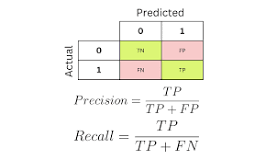

In [ ]:
#linear correlation is expected of a plot between in-sample test and y_pred 

ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [ ]:
#notice that this shape is unconventional. it should have a gradient of +1 and it is showing -1 now.

In [ ]:
Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = X_selected_df.index)

In [ ]:
X_selected_df

In [ ]:
X_traintest3 = X.copy()
X_traintest3["signal"] = Y_pred_logistic2_df
X_traintest3["signal"].iloc[:13] = 0

In [ ]:
X_traintest3["signal"]

In [ ]:
X_traintest3

In [ ]:
X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])
#((X_traintest3["strategy_return"] + 1).cumprod() * capital).plot(ax=ax, label = "logistic regression")
(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")
#((1+Y).cumprod() * capital).plot(ax=ax, label = "simple return")
(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Long-only Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()
#capital * (1 + X_traintest3["strategy_return"]).cumprod().plot(figsize=[16,12])

In [ ]:
X_traintest3["strategy_return"].sum()

In [ ]:
X_traintest3

In [ ]:
MLmodel_data=pd.concat([spy,X_traintest3[['signal']]], axis=1)
MLmodel_data=MLmodel_data.rename(columns={'signal':'Position'})

In [ ]:
Backtest_ML_Strategy=Backtest(MLmodel_data,100000,0)
Backtest_ML_Strategy.plot_all_stats()

In [ ]:
Backtest_ML_Strategy.data

In [ ]:
X_traintest3["signal"].shift(1)

In [ ]:
Y

In [ ]:
cumu_ret = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]

In [ ]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

In [ ]:
cumu_ret

In [ ]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

In [ ]:
X_traintest3["signal"].value_counts()

In [ ]:
#what if we can short?

In [ ]:
signal = X_traintest3["signal"].copy()
short_signal = (signal == 0) * -1 
signals = short_signal + signal

signals.iloc[:12] = 0
signals.value_counts()
#X_traintest3["signal"].iloc[:12] = 0
#X_traintest3["signal"].value_counts()


In [ ]:
X_traintest3_copy = X_traintest3.copy()
X_traintest3_copy["signal"] = signals

In [ ]:
X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Long&Short Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()


In [ ]:
X_traintest3

In [ ]:
#cumu_ret_w_short = ((X_traintest3["strategy_return"] + 1).cumprod() * capital).iloc[-3]

In [ ]:
cumu_ret_w_short = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]
X_traintest3["strategy_return"].cumsum().apply(np.exp)

In [ ]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

In [ ]:
cumu_ret_w_short

In [ ]:
(cumu_ret_w_short - cumu_ret)/ max(cumu_ret_w_short, cumu_ret)

In [ ]:
(cumu_ret_w_short - cumu_ret)/ cumu_ret

# with optimization of the decision threshold value and best k of feature engineering and alpha in elastic net

In [ ]:
X_traintest

In [ ]:
#transform X_selected into dataframe

X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)
X_selected_df

# need to perform optimization of k 

In [ ]:
#Feature Engineering

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression


"""
optimize k with mse of linear regression
to do that, i need to turn this into a function
inputs that i need are : X_traintest, Y_traintest, years_in_data, k_ = "all"

if k_ != "all":
    k_ = "all"
"""

#initiate dictionary to hold data from df.loc[:year]
df_dict = {}

years_in_data = pd.unique(X_traintest.index.year)

def get_feature_engr(X_traintest, Y_traintest, years_in_data, *args):
    
    k_ = args[0] if args else "all"
    
    for year_ in years_in_data:
        mask =\
        (X_traintest
         .columns[
                     X_traintest
                    .apply(lambda col: col.loc[X_traintest.index.year == year_].isna().mean() < 0.3)
                 ]
        )

        X_traintest_to_year = X_traintest.loc[:str(year_), mask].copy()

        #Feature scaling, consideration of not removing mean so that the values wont go into negative

        X_traintest_to_year =\
        (
            X_traintest_to_year
            /
            X_traintest_to_year.max()
        )

        Y_traintest_to_year = Y_traintest.loc[:str(year_)]

        poly = PolynomialFeatures(degree=3)

        #we are shifting the Y values because we need to train the model for a 1 day look ahead
        index_ =\
        (Y_traintest_to_year
         .shift(-1)
         .dropna()
         .index 
        )

        X_poly = poly.fit_transform(X_traintest_to_year.loc[index_])  
        #(R-squared / (1 - R-squared)) * ((n - unrestricted k - 1) / m), m is total number of unrestricted parameters-1

        selector = SelectKBest(score_func=f_regression, k=10) 

        X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

        X_columns = selector.get_feature_names_out()

        #transform X_selected into dataframe
        X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

        #make sure no missing values
        X_selected_df = X_selected_df.ffill()

        #columns = X_selected_df.columns 

        df_dict[year_] = X_selected_df
        
    return df_dict #X_columns can be retrieved from df_dict[year].columns

# analysis: we did feature scaling of z score, use polynomial featuring to overfit and use f-statistics to determine the top variables. Optimization will render this parameter data-centric and it won't require any human input. this leverages on the strength of automation and allowing data to decide the ideal paramter, based on MSE score.

In [ ]:
df_dict = get_feature_engr(X_traintest, Y_traintest, years_in_data)

In [ ]:
df_dict[2005]

In [ ]:
# Model Specification

penalty_ = 0.0

def fit_and_predict(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_) #alpha is set lower here than above to reduce penalty

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long only    
        
        X_traintest3 = X.copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:12] = 0

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long-only Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

In [ ]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day lookahead

params, X_traintest4= fit_and_predict(df_dict,Y_traintest2,penalty_)

In [ ]:
X_traintest4["signal"].value_counts()

In [ ]:
(X_traintest4["strategy_return"].cumsum().apply(np.exp))

In [ ]:
#can turn into a plot function

#linear correlation is expected of a plot between in-sample test and y_pred 
                    #params_dict[]
ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [ ]:
#this can be removed later. this is a long-short strategy 

penalty_ = 0.0

def fit_and_predict_w_short(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long and short
        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:13] = 0
        
        signal = X_traintest3["signal"].copy()
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal
        signals.iloc[:12] = 0
        
        X_traintest3["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long&Short Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

In [ ]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day look-ahead

params, X_traintest5= fit_and_predict_w_short(df_dict,Y_traintest2,penalty_)



In [ ]:
(X_traintest5["strategy_return"].cumsum().apply(np.exp))

In [ ]:
X_traintest5.signal.value_counts()

# CART (decision tree)

In [ ]:
# Model Specification

penalty_ = 0.0

def fit_and_predict_DT(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        DT_model = DecisionTreeRegressor(criterion = "squared_error")

        DT_model.fit(df_dict[year_], Y_traintest_series_fraction)

        DT_pred_train2 = DT_model.predict(df_dict[year_])
        
        train_result = mean_squared_error(DT_pred_train2, Y_traintest_series_fraction)

        DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index = df_dict[year_].index)
        
        print("MSE is {}".format(train_result))

#         params_dict[f"EN_pred_{year_}"] = EN_pred_train2
#         params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
#         params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

#         params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
#         params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
#         params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
#         print("Name of features used: {}".format(elastic_net.feature_names_in_))
#         print(" ")
#         print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
#         print(" ")
#         print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
#         print(" ")
#         print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))

        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = DT_pred_train2_df
        X_traintest3["signal"].iloc[:12] = 0
        X_traintest3["signal"] = (X_traintest3["signal"] > 0).astype(int)
        
        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "CART (classification)")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Long-only Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

In [ ]:
Y_traintest2

In [ ]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_] #1 day look-ahead
dummy_df = fit_and_predict_DT(df_dict,Y_traintest2,penalty_)[1]

In [ ]:
dummy_df["signal"].hist(bins=100)

In [ ]:
dummy_df["signal"].value_counts()

In [ ]:
dummy_df["strategy_return"].cumsum().apply(np.exp)